# 🍽 Zomato Data Analysis — Improved (v2)
Using your dataset (**Zomatodata.csv**, 148 rows).

**Goal:** Turn EDA into validated, defensible insights with hypothesis tests and regression.

## Step‑by‑Step Overview
1) Setup & imports
2) Load data
3) Sanity checks (schema, NAs, stats)
4) Clean ratings (parse + winsorize)
5) Hypothesis test (online order → higher ratings?)
6) Effect size + 95% CI
7) Control confounders via OLS
8) Visual checks (boxplots, distributions)
9) Conclusions & next steps

### 1) Setup & Imports

In [1]:
# !pip install pandas numpy scipy statsmodels matplotlib seaborn
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.formula.api as smf
pd.set_option('display.max_columns', 200)

### 2) Load Data

In [3]:
DATA_PATH = 'Zomatodata.csv'  # set to your file path if running elsewhere
df = pd.read_csv(DATA_PATH)
df.head()

,name,online_order,book_table,rate,votes,approx_cost(for two people),listed_in(type)
0,Jalsa,Yes,Yes,4.1/5,775,800,Buffet
1,Spice Elephant,Yes,No,4.1/5,787,800,Buffet
2,San Churro Cafe,Yes,No,3.8/5,918,800,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7/5,88,300,Buffet
4,Grand Village,No,No,3.8/5,166,600,Buffet


### 3) Sanity Checks

In [4]:
display(df.info())
display(df.isnull().sum())
display(df.describe(include='all').T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   name                         148 non-null    object
 1   online_order                 148 non-null    object
 2   book_table                   148 non-null    object
 3   rate                         148 non-null    object
 4   votes                        148 non-null    int64 
 5   approx_cost(for two people)  148 non-null    int64 
 6   listed_in(type)              148 non-null    object
dtypes: int64(2), object(5)
memory usage: 8.2+ KB


None

name                           0
online_order                   0
book_table                     0
rate                           0
votes                          0
approx_cost(for two people)    0
listed_in(type)                0
dtype: int64

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,148,145,San Churro Cafe,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
online_order,148,2,No,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
book_table,148,2,No,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rate,148,20,3.8/5,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
votes,148.0,NaN,NaN,NaN,264.810811,653.676951,0.0,6.75,43.5,221.75,4884.0
approx_cost(for two people),148.0,NaN,NaN,NaN,418.243243,223.085098,100.0,200.0,400.0,600.0,950.0
listed_in(type),148,4,Dining,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4) Clean Ratings (parse '4.2/5' → 4.2) & Winsorize
**Why:** Numeric ratings required for statistics; winsorization reduces outlier sensitivity.

In [5]:
def parse_rate(x):
    try:
        if isinstance(x, str) and '/' in x:
            return float(x.split('/')[0])
        return np.nan if pd.isna(x) else float(x)
    except: return np.nan
df['rate_clean'] = df['rate'].apply(parse_rate)
low, high = df['rate_clean'].quantile([0.01, 0.99])
df['rate_winz'] = df['rate_clean'].clip(lower=low, upper=high)
df[['rate_clean','rate_winz']].describe()

,rate_clean,rate_winz
count,148.000000,148.000000
mean,3.633108,3.633189
std,0.402271,0.396143
min,2.600000,2.800000
25%,3.300000,3.300000
50%,3.700000,3.700000
75%,3.900000,3.900000
max,4.600000,4.506000


### 5) Hypothesis Test: Online Order vs Rating
**Question:** Do online‑order restaurants have higher ratings?
Test = Welch’s t‑test; also compute effect size (Cohen’s d) and 95% CI.

In [7]:
a = df.loc[df['online_order']=='Yes','rate_winz'].dropna()
b = df.loc[df['online_order']=='No','rate_winz'].dropna()
t_stat, p_value = st.ttest_ind(a, b, equal_var=False)
cohen_d = (a.mean()-b.mean())/np.sqrt((a.var(ddof=1)+b.var(ddof=1))/2)
diff = a.mean() - b.mean()
se = np.sqrt(a.var(ddof=1)/len(a) + b.var(ddof=1)/len(b))
ci_low, ci_high = diff - 1.96*se, diff + 1.96*se
print({'mean_yes':a.mean(), 'mean_no':b.mean(), 'diff':diff,
       't':t_stat, 'p_value':p_value, 'cohen_d':cohen_d, '95%CI':(ci_low, ci_high)})

{'mean_yes': np.float64(3.855379310344828), 'mean_no': np.float64(3.4899999999999998), 'diff': np.float64(0.3653793103448284), 't': np.float64(6.016418730894571), 'p_value': np.float64(2.175802444345839e-08), 'cohen_d': np.float64(1.0215339168618478), '95%CI': (np.float64(0.24634779337303986), np.float64(0.48441082731661694))}


### 6) Control for Confounders (OLS)
Include `book_table`, `listed_in(type)`, `votes`, and `approx_cost(for two people)` as controls.
Interpret the coefficient of `C(online_order)[T.Yes]`.

In [8]:
model_df = df[['rate_winz','online_order','book_table','listed_in(type)','votes','approx_cost(for two people)']].dropna()
model_df['online_order'] = model_df['online_order'].astype('category')
model_df['book_table'] = model_df['book_table'].astype('category')
model_df['listed_in(type)'] = model_df['listed_in(type)'].astype('category')
formula = 'rate_winz ~ C(online_order) + C(book_table) + C(Q("listed_in(type)")) + votes + Q("approx_cost(for two people)")'
ols = smf.ols(formula, data=model_df).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:              rate_winz   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     11.11
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           3.91e-11
Time:                        21:11:47   Log-Likelihood:                -39.752
No. Observations:                 148   AIC:                             95.50
Df Residuals:                     140   BIC:                             119.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

### 7) Visual Checks

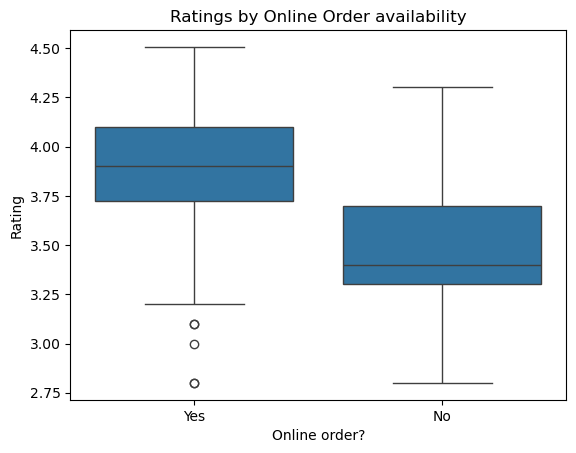

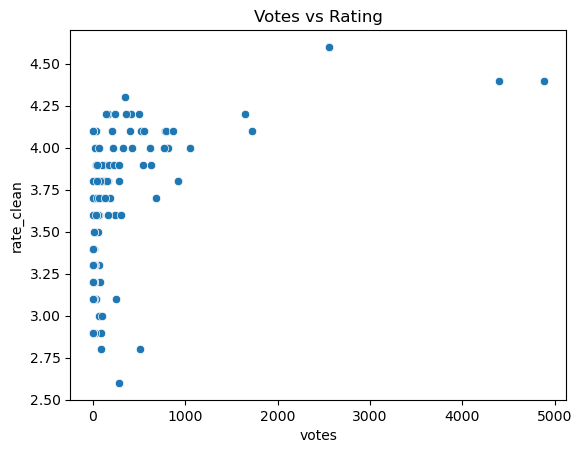

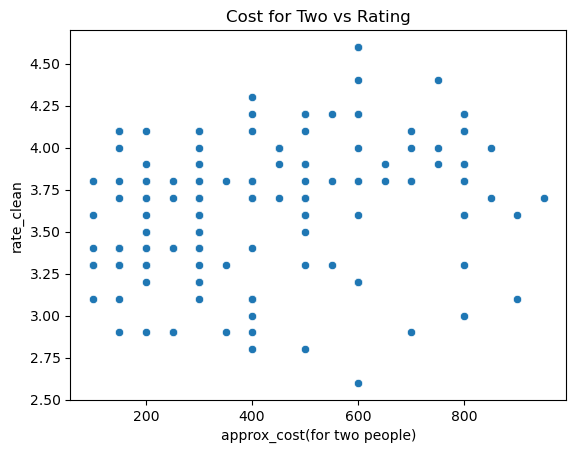

In [9]:
import seaborn as sns
sns.boxplot(x=df['online_order'], y=df['rate_winz'])
plt.title('Ratings by Online Order availability'); plt.xlabel('Online order?'); plt.ylabel('Rating'); plt.show()
sns.scatterplot(x=df['votes'], y=df['rate_clean'])
plt.title('Votes vs Rating'); plt.show()
sns.scatterplot(x=df['approx_cost(for two people)'], y=df['rate_clean'])
plt.title('Cost for Two vs Rating'); plt.show()

### 8) Conclusions — Fill after running
- **Online order mean rating:** Yes=3.855, No=3.49
- **Difference:** 0.365 | **t:** 6.016 | **p:** 0.0000 | **d:** 1.022 | **95% CI:** (0.246, 0.484)
- **OLS coef for online_order=Yes:** 0.22 (p=0.0005)
- **Corr:** votes↔rating=0.49, cost↔rating=0.275
- **Top avg ratings by type (preview):** see README